In [2]:
%matplotlib inline

In [13]:
import numpy as np
import scipy
import random
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# 1. Make inference about underlying distributions

### (a) Number of isthmus clones per HF in dependence of labelling efficiency.

In [4]:
#upload empirical data

clones_per_HF_emp = pd.DataFrame(index = ['AS51:1','AS51:2','AS48:1','AS90:7','AS42:2','AS42:1','AS90:4','AS122:3','AS152:7'], columns = range(5))

clones_per_HF_emp.ix['AS51:1'] = [16,6,10,0,0]
clones_per_HF_emp.ix['AS51:2'] = [2,2,1,0,0]
clones_per_HF_emp.ix['AS48:1'] = [23,13,0,0,0]
clones_per_HF_emp.ix['AS90:7'] = [9,11,1,0,0]
clones_per_HF_emp.ix['AS42:2'] = [11,9,2,0,0]
clones_per_HF_emp.ix['AS42:1'] = [2,10,0,0,0]
clones_per_HF_emp.ix['AS90:4'] = [5,5,3,1,0]
clones_per_HF_emp.ix['AS122:3'] = [3,5,7,1,0]
clones_per_HF_emp.ix['AS152:7'] = [3,8,5,6,0]

In [6]:
#calculate mu and var for each measurement

clones_per_HF_par = pd.DataFrame(index = clones_per_HF_emp.index, columns = ['mean', 'variance'])

for ix in enumerate(clones_per_HF_emp.index):
     
    y = clones_per_HF_emp.ix[ix[1]]
    
    #define mu and sigma
    
    y_list = []
    
    for val in enumerate(y):
        y_list += [val[0]] * val[1]
    
    mu = np.mean(y_list)
    sigma = np.var(y_list)
    
    clones_per_HF_par.ix[ix[1]] = [mu, sigma]
    
print clones_per_HF_par

              mean   variance
AS51:1      0.8125  0.7773438
AS51:2         0.8       0.56
AS48:1   0.3611111  0.2307099
AS90:7   0.6190476  0.3310658
AS42:2   0.5909091  0.4235537
AS42:1   0.8333333  0.1388889
AS90:4           1  0.8571429
AS122:3      1.375   0.734375
AS152:7   1.636364   1.049587


In [7]:
#define linear function of sigma in dependence of mu without intercept

x_tmp = np.array(clones_per_HF_par['mean'])
y_tmp = np.array(clones_per_HF_par['variance'])

x_tmp = x_tmp[:,np.newaxis]

slope, _, _, _, = np.linalg.lstsq(x_tmp, y_tmp)

slope = slope[0]

print slope

0.631197613946


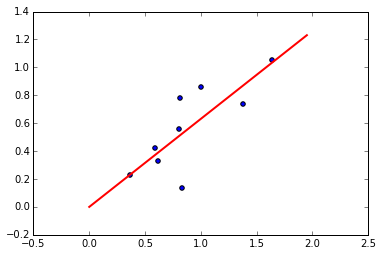

In [9]:
#plot regression line

plt.scatter(x_tmp, y_tmp)

plt.plot(np.arange(0, 2.0, 0.05), np.arange(0, 2.0, 0.05) * slope, linewidth = 2, color = 'r')

Gamma distributions are dependent on shape $k$ and scale $\theta$ and have a mean

$\mu = k\theta$

and a variance

$\sigma = k\theta(1+\theta)$;

therefore 

$k = \mu / (r-1)$

and 

$\theta = r - 1$

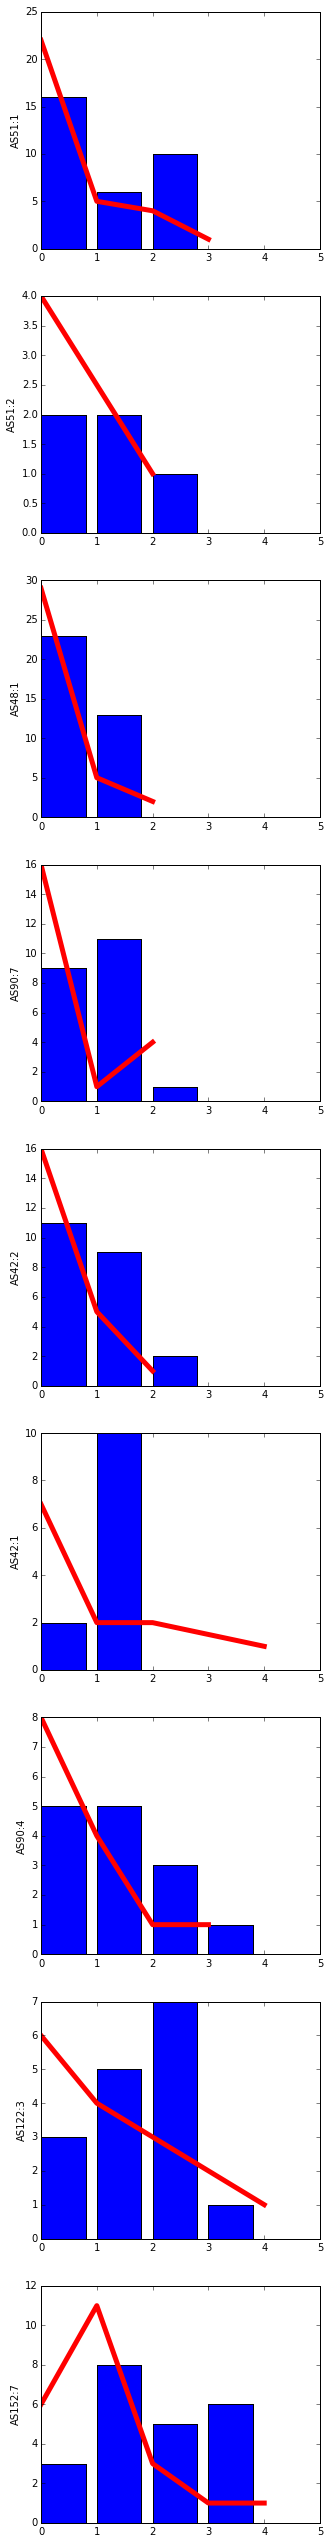

In [15]:
#plot empirical and sampled distribution and 

fig = plt.figure(facecolor = 'w', figsize = (5, 5 * len(clones_per_HF_emp.index)))

x = clones_per_HF_emp.columns

for ix in enumerate(clones_per_HF_emp.index):
    
    y = clones_per_HF_emp.ix[ix[1]]
        
    #plot bars
    
    ax = plt.subplot(len(clones_per_HF_emp.index),1,ix[0] + 1)
    
    ax.bar(x, y)
    
    ax.set_ylabel(ix[1])
    
    #define parameters for sampling
    
    n = clones_per_HF_emp.ix[ix[1]].sum()
    
    mu = clones_per_HF_par.ix[ix[1], 'mean']
    
    r = slope

    k = mu / r + 0.000001 #added so that k always > 0

    theta = r
    
    #sample and plot
    
    results_tmp = []

    for it in range(n):
    
        lam = np.random.gamma(k, theta)
    
        sample = np.random.poisson(lam)
    
        results_tmp.append(sample)
        
    results_tmp = Counter(results_tmp)
        
    ax.plot(results_tmp.keys(),
            results_tmp.values(),
            linewidth = 5, color = 'r')

# 2. Initialize functions

In [26]:
def Sim_CCC(IST_labels_per_HF_range, color_prob_SG, color_prob_IST, iterations, clones_per_experiment, 
            dispersion_r = 0.6311, return_dict = False):
    
    """
    Simulates SG-isthmus clone color correlation defined as in Füllgrabe et al. under the assumption that SG and IST populations
    are fully independent of each other and clone color in SG and IST are the results of a stochastic process.
    -----
    IST_labels_per_HF_range: np.arange [float] of average IST clone numbers per HF.
    color_prob_SG: dict containing SG color probabilities [float, must add up to 1.0] for 'r', 'b', 'y', 'g'.
    color_prob_IST: dict containing IST color probabilities [float, must add up to 1.0] for 'r', 'b', 'y', 'g'.
    iterations: number [int] of experiment repeats.
    clones_per_experiment: number [int] of SG-IST correlations analyzed per experiment.
    -----
    returns pd.DataFrame
    """
    
    #initialize results file
        
    results = pd.DataFrame (index = ['corr', 'corr_2sigma', 
                                     'non_corr', 'non_corr_2sigma',
                                     'no_lab', 'no_lab_2sigma'], 
                            columns = IST_labels_per_HF_range)
    
    results_dict = {}
    
    #initialize SG and IST color_choice as string of n colors proportional to color probability (4th decimal)
    
    color_choice_SG = ''
    color_choice_IST = ''

    for key in color_prob_SG:
    
        color_choice_SG += key * int(color_prob_SG[key] * 10000)
        
    for key in color_prob_IST:
        
        color_choice_IST += key * int(color_prob_IST[key] * 10000)
        
    #iterate through labeling efficiencies
    
    for label_eff in IST_labels_per_HF_range:
        
        #calculate parameters for Gamma distribution

        k = (label_eff / (dispersion_r - 1)) + 0.000001 #added so that k always > 0

        theta = dispersion_r - 1
        
        #initialize list of percentages for corr, non_corr and no_lab events
        
        corr, non_corr, no_lab = [], [], []
        
        #iterate through experiment repeats
        
        for it in range(iterations):
            
            #initialize counts of correlated, non_correlated and non-labelled repeats
    
            corr_count, non_corr_count, no_lab_count = 0,0,0
                
            #iterate throught number of analyzed SG clones

            for SG_clone in range(clones_per_experiment):
                
                #chose SG clone color
            
                SG_c = random.choice(color_choice_SG)
                
                #initialize IST color list
            
                IST_c = []
                
                #chose and iterate through number of IST labels (Gamma-Poisson function as specified above)
            
                for l in range(np.random.poisson(lam = np.random.gamma(k, theta))):
                
                    IST_c.append(random.choice(color_choice_IST))
        
                #define whether label is correlated, uncorrelated or not present
            
                if len(IST_c) == 0:
                
                    no_lab_count += 1
                
                elif len(IST_c) > 0 and SG_c in IST_c:
                
                    corr_count += 1
                
                elif len(IST_c) > 0 and SG_c not in IST_c:
                
                    non_corr_count += 1
                    
            #calculate fractional values and update results
                
            corr.append(float(corr_count) / float(clones_per_experiment))
            non_corr.append(float(non_corr_count) / float(clones_per_experiment))
            no_lab.append(float(no_lab_count) / float(clones_per_experiment))
                    
        #save raw data in results dict
        
        results_dict[label_eff] = {'corr':corr,'non_corr':non_corr,'no_lab':no_lab}
        
        #save means in results DataFrame
            
        results.ix['corr', label_eff] = np.mean(corr)
        results.ix['corr_2sigma', label_eff] = np.std(corr) * 2
        results.ix['non_corr', label_eff] = np.mean(non_corr)
        results.ix['non_corr_2sigma', label_eff] = np.std(non_corr) * 2
        results.ix['no_lab', label_eff] = np.mean(no_lab)
        results.ix['no_lab_2sigma', label_eff] = np.std(no_lab) * 2
            
    if return_dict == True:
        
        return results, results_dict
    
    else:
        
        return results

In [27]:
def drawSim_CCC(sim_results, emp_results = None):
    
    #create figure
    
    fig = plt.figure(facecolor = 'w', figsize = (14,10))
    ax0 = plt.axes()
    
    #create x-axis
    
    ax0.set_xlim(np.min(list(sim_results.columns)), np.max(list(sim_results.columns)))
    ax0.set_xticks(np.arange(np.min(list(sim_results.columns)), np.max(list(sim_results.columns)), 0.1))
    ax0.set_xticklabels(np.arange(np.min(list(sim_results.columns)), np.max(list(sim_results.columns)), 0.1), 
                        family = 'Arial', fontsize = 15)
    ax0.set_xlabel('Ist labels per HF', family = 'Arial', fontsize = 25)
    
    #create y-axis
    ax0.set_ylim(0.0, 1.0)
    ax0.set_yticks(np.arange(0.0, 1.01, 0.1))
    ax0.set_yticklabels(np.arange(0.0, 1.01, 0.1), family = 'Arial', fontsize = 15)
    ax0.set_ylabel('Probability', family = 'Arial', fontsize = 25)
    
    #plot correlated
    
    ax0.plot(sim_results.columns,
             sim_results.ix['corr'].values,
             linewidth = 3,
             color = 'red')
    
    #plot correlated 2 sigma fill
    
    ax0.fill_between(sim_results.columns,
                     [val for val in sim_results.ix['corr'] + sim_results.ix['corr_2sigma']],
                     [val for val in sim_results.ix['corr'] - sim_results.ix['corr_2sigma']],
                     color = 'red', alpha = 0.25)
    
    #plot non-correlated
    
    ax0.plot(sim_results.columns,
             sim_results.ix['non_corr'].values,
             linewidth = 3,
             color = 'green')
    
    #plot non-correlated 2 sigma fill
    
    ax0.fill_between(sim_results.columns,
                     [val for val in sim_results.ix['non_corr'] + sim_results.ix['non_corr_2sigma']],
                     [val for val in sim_results.ix['non_corr'] - sim_results.ix['non_corr_2sigma']],
                     color = 'green', alpha = 0.25)
    
    #plot no label
    
    ax0.plot(sim_results.columns,
             sim_results.ix['no_lab'].values,
             linewidth = 3,
             color = 'blue')
    
    ax0.fill_between(sim_results.columns,
                     [val for val in sim_results.ix['no_lab'] + sim_results.ix['no_lab_2sigma']],
                     [val for val in sim_results.ix['no_lab'] - sim_results.ix['no_lab_2sigma']],
                     color = 'blue', alpha = 0.25)
    
    #plot empirical datapoints
    
    if emp_results is not None:
        
        ax0.scatter(emp_results.columns, emp_results.ix['corr'], s = 250, color = 'red')
        ax0.scatter(emp_results.columns, emp_results.ix['non_corr'], s = 250, color = 'green')
        ax0.scatter(emp_results.columns, emp_results.ix['no_lab'], s = 250, color = 'blue')
        
    #plot labels
    
    ax0.text(np.max(list(sim_results.columns)) * 1.01,
             sim_results.ix['corr', np.max(list(sim_results.columns))],
             'Correlated', color = 'red', family = 'Arial', fontsize = 25, va = 'center')
    
    ax0.text(np.max(list(sim_results.columns)) * 1.01,
             sim_results.ix['non_corr', np.max(list(sim_results.columns))],
             'Non-correlated', color = 'green', family = 'Arial', fontsize = 25, va = 'center')
    
    ax0.text(np.max(list(sim_results.columns)) * 1.01,
             sim_results.ix['no_lab', np.max(list(sim_results.columns))],
             'No labeling', color = 'blue', family = 'Arial', fontsize = 25, va = 'center')

# 3. Load data (average)

In [28]:
IST_labels_per_HF_range = np.arange(0.0, 2.0, 0.05)

In [29]:
color_prob_SG = {'b':0.0189, 'r':0.3744, 'y':0.3744, 'g' : 0.2322}
color_prob_IST = {'b':0.0802, 'r':0.3209, 'y':0.3827, 'g':0.2160}

In [30]:
iterations = 1000

In [31]:
clones_per_experiment = 21

In [32]:
emp_results = pd.DataFrame(index = ['corr','non_corr','no_lab'])

emp_results[0.787878788] = [0.4054, 0.0541, 0.5405]
emp_results[0.590909091] = [0.2083, 0.375, 0.4166]
emp_results[1.666666667] = [0.3333, 0.5833, 0.0833]
emp_results[0.636363636] = [0.3333, 0.2083, 0.4583]
emp_results[0.857142857] = [0.3333, 0.1667, 0.5000]
emp_results[1.375] = [0.3684, 0.4737, 0.1579]
emp_results[0.692307692] = [0.4285, 0.2142, 0.3571]
emp_results[1.0] = [0.55, 0.10, 0.35]
emp_results[0.286] = [0.2857, 0.0, 0.7142]
emp_results[0.588] = [0.361, 0.222, 0.417]

# 4. Simulate and draw

In [33]:
sim_results = Sim_CCC(IST_labels_per_HF_range, color_prob_SG, color_prob_IST, iterations, clones_per_experiment)

ValueError: scale <= 0

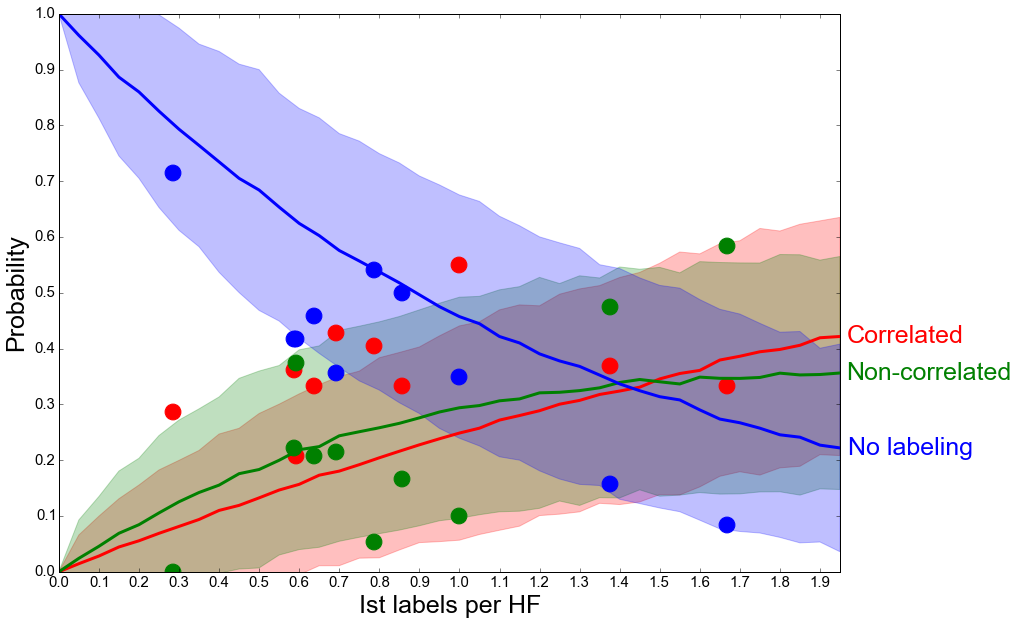

In [25]:
drawSim_CCC(sim_results, emp_results=emp_results)

In [25]:
sim_results.to_csv(path_or_buf = 'SG_correlation_sim_results.txt', sep = '\t')

# 5. Load data (inversed experiment)

In [4]:
SG_labels_per_HF_range = np.arange(0.0, 2.0, 0.05)

In [7]:
color_prob_SG = {'b':0.081683168,'r':0.386138614,'y':0.383663366,'g':0.148514851}
color_prob_IST = {'b':0.0234375,'r':0.359375,'y':0.3671875,'g':0.25}

In [6]:
iterations = 100000

In [9]:
clones_per_experiment = 45

In [15]:
emp_results_inv = pd.DataFrame(index = ['corr','non_corr','no_lab'])

emp_results_inv[0.65] = [0.278, 0.167, 0.556]
emp_results_inv[0.47] = [0.132, 0.211, 0.658]
emp_results_inv[0.33] = [0.093, 0.268, 0.639]
emp_results_inv[0.27] = [0.148, 0.111, 0.741]
emp_results_inv[0.25] = [0.133, 0.200, 0.667]
emp_results_inv[0.57] = [0.200, 0.311, 0.489]
emp_results_inv[0.31] = [0.158, 0.079, 0.763]
emp_results_inv[0.57] = [0.367, 0.133, 0.500]
emp_results_inv[0.68] = [0.394, 0.212, 0.394]

### 4. Simulate and draw (inversed experiment)

In [10]:
sim_results_inverse = Sim_CCC(SG_labels_per_HF_range, color_prob_IST, color_prob_SG, iterations, clones_per_experiment)

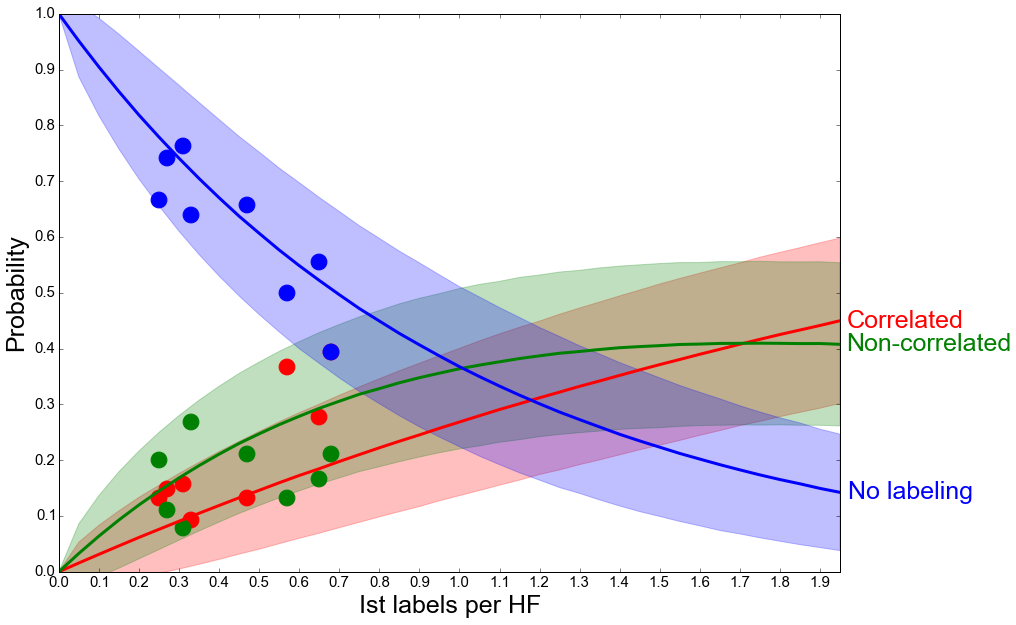

In [16]:
drawSim_CCC(sim_results_inverse, emp_results=emp_results_inv)